
# Simulazione di caching basato su similarità di prompt (CLIP) con due politiche di eviction: LRU e LFU

## Prerequisiti:
  pip install huggingface_hub pandas transformers torch torchvision
Su macOS con MPS, installa torch con:
   pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/mps


In [18]:

import random
import pandas as pd
import torch
from huggingface_hub import hf_hub_download
from collections import OrderedDict, defaultdict
from transformers import CLIPTokenizer, CLIPModel



# 1) Setup device (MPS su Mac, altrimenti CPU)


In [19]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS device")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA device: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using Apple MPS device


# 2) Setup CLIP per embedding testuale

In [20]:
clip_model_name = "openai/clip-vit-base-patch32"
tokenizer = CLIPTokenizer.from_pretrained(clip_model_name)
model = CLIPModel.from_pretrained(clip_model_name).to(device)
model.eval()

def embed_prompt(prompt: str) -> torch.Tensor:
    """
    Ritorna embedding L2-normalizzato del prompt.
    """
    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        emb = model.get_text_features(**inputs)
    return emb / emb.norm(p=2, dim=-1, keepdim=True)

# 3) Cache similarity con politiche di eviction

LRU (Least Recently Used) e LFU (Least Frequently Used)

In [39]:
class SimilarityLRUCache:
    """Cache similarity + eviction LRU"""
    def __init__(self, capacity: int, threshold: float):
        self.capacity = capacity
        self.threshold = threshold
        # ordered dict: prompt -> (embedding)
        self.cache = OrderedDict()

    def query(self, prompt: str) -> bool:
        """
        Se esiste un item in cache con sim >= threshold -> hit, aggiorna MRU.
        Altrimenti -> miss.
        """
        q_emb = embed_prompt(prompt)
        best_key, best_sim = None, -1.0
        # cerca best match
        for key, emb in self.cache.items():
            sim = float((emb @ q_emb.T).item())
            if sim > best_sim:
                best_key, best_sim = key, sim
        if best_sim >= self.threshold:
            # hit: aggiorna ordine
            self.cache.move_to_end(best_key)
            return True
        # miss
        self._add(prompt, q_emb)
        return False

    def _add(self, prompt: str, emb: torch.Tensor):
        if len(self.cache) >= self.capacity:
            # rimuovi LRU
            self.cache.popitem(last=False)
        self.cache[prompt] = emb

class SimilarityLFUCache:
    """Cache similarity + eviction LFU"""
    def __init__(self, capacity: int, threshold: float):
        self.capacity = capacity
        self.threshold = threshold
        # store prompt -> embedding, and freq count
        self.cache = {}
        self.freq = defaultdict(int)

    def query(self, prompt: str) -> bool:
        q_emb = embed_prompt(prompt)
        best_key, best_sim = None, -1.0
        for key, emb in self.cache.items():
            sim = float((emb @ q_emb.T).item())
            if sim > best_sim:
                best_key, best_sim = key, sim
        if best_sim >= self.threshold:
            # hit: incrementa freq
            self.freq[best_key] += 1
            return True
        # miss
        self._add(prompt, q_emb)
        return False

    def _add(self, prompt: str, emb: torch.Tensor):
        if len(self.cache) >= self.capacity:
            # rimuovi LFU
            min_freq = min(self.freq.values())
            # trova una chiave con freq minima
            for key, f in list(self.freq.items()):
                if f == min_freq:
                    del self.cache[key]
                    del self.freq[key]
                    break
        self.cache[prompt] = emb
        self.freq[prompt] = 1

# Management of Prompt Dataset

In [71]:
class PromptDatasetManager:
    def __init__(self, repo_id="poloclub/diffusiondb", filename="metadata.parquet", max_size=None):
        print("Scaricamento metadata.parquet...")
        self.meta_path = hf_hub_download(
            repo_id=repo_id, repo_type="dataset", filename=filename
        )
        if max_size:
            self.df = pd.read_parquet(self.meta_path).head(max_size)
        else:
            self.df = pd.read_parquet(self.meta_path)
        print(f"Colonne disponibili: {list(self.df.columns)}\n")

    def getRandomPrompt(self):
        """
        Restituisce una funzione lambda che, ad ogni chiamata,
        restituisce un nuovo prompt casuale dal database.
        """
        prompts = self.df['prompt'].dropna().tolist()
        return lambda: random.choice(prompts)

    def  getDataFrame(self):
        """
        Restituisce il DataFrame completo.
        Se il DataFrame è molto grande, considera di usare `head()` per limitare le righe.
        """
        return self.df
    
    
    def getRandomUserSession(self, session_gap: int = 30, max_prompts: int = 100):
        """
        Restituisce una funzione che genera sessioni di un utente casuale.

        Ogni sessione contiene un numero casuale di prompt (fino a `max_prompts`),
        con un intervallo di tempo casuale tra i prompt (fino a `session_gap` minuti).
        """
        users = self.df['user_name'].dropna().unique()
        if len(users) == 0:
            raise ValueError("Nessun utente trovato nel DataFrame.")
        
        def generate_session():
            user = random.choice(users)
            df_user = self._get_user_sessions(user, session_gap)
            num_prompts = random.randint(1, max_prompts)
            session_df = df_user.sample(n=num_prompts, replace=True)
            return user, session_df
        
        return generate_session

    def _get_user_sessions(self,
                          user_name: str,
                          session_gap: int = 30) -> pd.DataFrame:
        """
        Estrae dal DataFrame tutte le righe di un dato `user_name`, ordina per timestamp
        e assegna un `session_id` incrementale ogni volta che l'intervallo tra richieste
        successive supera `session_gap` minuti.
        Restituisce un DataFrame con colonne originali + 'session_delta' + 'session_id'.
        """
        if 'user_name' not in self.df.columns or 'timestamp' not in self.df.columns:
            raise ValueError("Le colonne 'user_name' e/o 'timestamp' non sono presenti.")
        df_user = self.df[self.df['user_name'] == user_name].copy()
        if df_user.empty:
            raise ValueError(f"Nessun dato per l'utente {user_name}")
        df_user = df_user.sort_values('timestamp').reset_index(drop=True)
        # Calcola delta in minuti
        df_user['session_delta'] = df_user['timestamp'].diff().dt.total_seconds() / 60.0
        # Assegna session_id
        session_ids = []
        current_id = 0
        for delta in df_user['session_delta']:
            if pd.isna(delta) or delta > session_gap:
                current_id += 1
            session_ids.append(current_id)
        df_user['session_id'] = session_ids
        return df_user

manager = PromptDatasetManager(max_size=200)

    

Scaricamento metadata.parquet...
Colonne disponibili: ['image_name', 'prompt', 'part_id', 'seed', 'step', 'cfg', 'sampler', 'width', 'height', 'user_name', 'timestamp', 'image_nsfw', 'prompt_nsfw']



In [72]:

print(manager.getDataFrame().head())


                                 image_name  \
0  2217ccbd-a1c6-47ac-9a2d-79649727c834.png   
1  c78807b7-d55a-4a2d-a6b6-9192b18941ad.png   
2  dc71658a-5e4b-4dca-861a-e1535510348b.png   
3  48eb7e17-a3cf-4eb8-96a9-d8e3e23fa1af.png   
4  601d9792-eccd-4850-97a7-edbe91d3464c.png   

                                              prompt  part_id        seed  \
0  a portrait of a female robot made from code, v...        1  2615452544   
1  a portrait of a female robot made from a cloud...        1  4231506957   
2      only memories remain, trending on artstation         1   544607824   
3                   dream swimming pool with nobody         1  3500509234   
4           a dog doing weights. epic oil painting.         1  1312381211   

   step   cfg  sampler  width  height  \
0    50   7.0        8    512     512   
1    50   7.0        8    512     512   
2    50   7.0        8    512     512   
3    50   7.0        8    512     512   
4    50  12.0        8    512     768   

       

# 4) Simulazione generale

In [73]:
from tqdm import trange

def simulate_similarity_cache(prompts, cache_obj, num_requests: int) -> float:
    hits = 0
    for _ in trange(num_requests, desc="Simulating requests"):
        p = random.choice(prompts)
        if cache_obj.query(p):
            hits += 1
    return hits / num_requests


In [75]:
random.seed(42)
# configurazione
MAX_PROMPTS = 50      # prompt unici
NUM_REQUESTS = 200    # richieste
CACHE_SIZE = 10        # capacità cache
SIM_THRESHOLD = 0.8    # soglia cosine



# istanzia il manager e ottieni la funzione lambda per prompt casuali
dataset_manager = PromptDatasetManager(max_size=MAX_PROMPTS)
prompt_fn = dataset_manager.getRandomPrompt()

# istanzia due politiche
caches = {
    "Similarity-LRU": SimilarityLRUCache(CACHE_SIZE, SIM_THRESHOLD),
    "Similarity-LFU": SimilarityLFUCache(CACHE_SIZE, SIM_THRESHOLD)
}

# esegui simulazione usando la funzione lambda
print("Risultati:")
for name, cache in caches.items():
    hits = 0
    for _ in range(NUM_REQUESTS):
        p = prompt_fn()
        if cache.query(p):
            hits += 1
    rate = hits / NUM_REQUESTS
    print(f"- {name} hit rate: {rate:.2%}")

Scaricamento metadata.parquet...
Colonne disponibili: ['image_name', 'prompt', 'part_id', 'seed', 'step', 'cfg', 'sampler', 'width', 'height', 'user_name', 'timestamp', 'image_nsfw', 'prompt_nsfw']

Risultati:
- Similarity-LRU hit rate: 33.00%
- Similarity-LFU hit rate: 35.00%


/var/folders/xc/7hdkthds19g1p1r2m6m9pnxm0000gn/T/ipykernel_9538/3847975930.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([INTRA_SIMS, EXTRA_SIMS], labels=['Intra-session', 'Extra-session'])


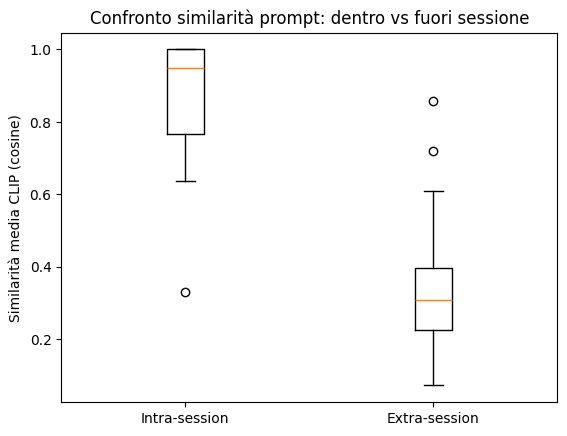

In [77]:
import matplotlib.pyplot as plt

NUM_SESSIONS = 50
SESSION_GAP = 30
INTRA_SIMS = []
EXTRA_SIMS = []

# Genera sessioni e calcola similarità intra-sessione
for _ in range(NUM_SESSIONS):
    user, session_df = manager.getRandomUserSession(session_gap=SESSION_GAP, max_prompts=20)()
    prompts = session_df['prompt'].tolist()
    if len(prompts) < 2:
        continue
    embeddings = torch.cat([embed_prompt(p) for p in prompts], dim=0)
    sims = []
    for i in range(1, len(embeddings)):
        sim = float((embeddings[i] @ embeddings[i-1].T).item())
        sims.append(sim)
    if sims:
        INTRA_SIMS.append(np.mean(sims))

# Calcola similarità extra-sessione (prompt casuali di utenti diversi)
all_prompts = manager.getDataFrame()['prompt'].dropna().sample(NUM_SESSIONS * 2).tolist()
for i in range(0, len(all_prompts), 2):
    emb1 = embed_prompt(all_prompts[i])
    emb2 = embed_prompt(all_prompts[i+1])
    sim = float((emb1 @ emb2.T).item())
    EXTRA_SIMS.append(sim)

# Boxplot confronto
plt.boxplot([INTRA_SIMS, EXTRA_SIMS], labels=['Intra-session', 'Extra-session'])
plt.ylabel("Similarità media CLIP (cosine)")
plt.title("Confronto similarità prompt: dentro vs fuori sessione")
plt.show()

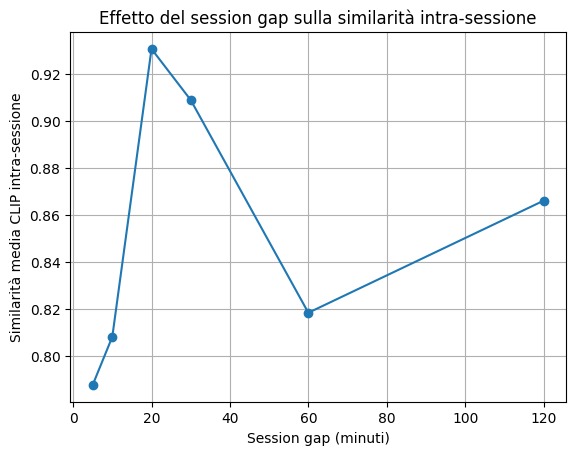

In [78]:
import numpy as np

import matplotlib.pyplot as plt

session_gaps = [5, 10, 20, 30, 60, 120]
NUM_SESSIONS = 30
intra_sim_means = []

for gap in session_gaps:
    sims = []
    for _ in range(NUM_SESSIONS):
        user, session_df = manager.getRandomUserSession(session_gap=gap, max_prompts=20)()
        prompts = session_df['prompt'].tolist()
        if len(prompts) < 2:
            continue
        embeddings = torch.cat([embed_prompt(p) for p in prompts], dim=0)
        for i in range(1, len(embeddings)):
            sim = float((embeddings[i] @ embeddings[i-1].T).item())
            sims.append(sim)
    if sims:
        intra_sim_means.append(np.mean(sims))
    else:
        intra_sim_means.append(np.nan)

plt.plot(session_gaps, intra_sim_means, marker='o')
plt.xlabel("Session gap (minuti)")
plt.ylabel("Similarità media CLIP intra-sessione")
plt.title("Effetto del session gap sulla similarità intra-sessione")
plt.grid(True)
plt.show()